# Final Assignment: 
## Capstone Project - The Battle of Neighborhoods (Week 2)

### **Table of contents¶**
#### 1. Introduction: Business Problem
#### 2. Data Requirements
#### 3. Methodology
#### 4. Analysis
#### 5. Results
#### 6. Discussion
#### 7. Conclusion

### 1. Introduction: Business Problem 
My project deals with analyzing the neighborhoods of Edmonton, the capital city of Alberta, Canada. 

The objective of this project is to analyze the neighbourhoods in Edmonton and divide them into different clusters based on the popular venues at each neighbourhood, by using data science methodology and machine learning techniques like clustering.
The target audience of this project is small business owners who want to set up their businesses like restaurants, coffee shops, beauty and health stores, etc.


#### Import necessary libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import random

from geopy.geocoders import Nominatim

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

!pip install folium
import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans


print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.1 MB/s  eta 0:00:01
Libraries imported.


### 2. Data requirements 

I use a ready dataset with Borough, Neighborhoods, Post Code and GPS coordinates from Wikipedia website: 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T

* The Foursquare API is used to access the venues in the neighborhoods 
* Then they are clustered based on their venues using Data Science Techniques, namely k-means algorithm is used.
* The optimal number of clusters can be obtained using silhouette coefficient
* Folium library can be used to visualize the clusters on the map of Edmonton 
* These clusters can be analyzed to help small business owners select a suitable location for their need like restaurants, coffee shops, beauty and health stores, hotels, shopping Malls 

The pre-processing and data cleaning involve scraping data of Alberta region with all neighborhoods, then extracting directly neighborhoods of Edmonton and scraping venue items. All the extracted data will be convert in to data frames for further analysis.

#### Scrapping the Wikipedia website

In [4]:
df= pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T')
df[1].head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


#### Converting data to pandas dataframe

In [5]:
df[1].to_csv('canada_data.csv')
df_canada = pd.read_csv('canada_data.csv')
df_canada.head()

,Unnamed: 0,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [6]:
df_canada.shape

(180, 6)

#### Cleaning the data

In [7]:
df1=df_canada.drop('Unnamed: 0', axis=True)
df2=df1.rename(columns={'Postal Code': 'PostalCode'})
df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [9]:
df2[df2['Neighborhood'] == 'Not assigned']
df3=df2[(df2['Neighborhood'] != 'Not assigned') & (df2['Latitude'] !='Not assigned') & (df2['Longitude'] !='Not assigned')]
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [10]:
df3.shape

(97, 5)

In [11]:
df3.dtypes

PostalCode      object
Borough         object
Neighborhood    object
Latitude        object
Longitude       object
dtype: object

#### Latitude and Longitude for some reason were as object, so i have to convert them to float

In [12]:
df3[['Latitude', 'Longitude']] = df3[['Latitude', 'Longitude']].astype(float)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
df3.dtypes

PostalCode       object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [14]:
df3.values.tolist()

[['T1A', 'Medicine Hat', 'Central Medicine Hat', 50.03646, -110.67925],
 ['T2A', 'Calgary', 'Penbrooke Meadows, Marlborough', 51.04968, -113.96432],
 ['T3A',
  'Calgary',
  'Dalhousie, Edgemont, Hamptons, Hidden Valley',
  51.12606,
  -114.143158],
 ['T4A', 'Airdrie', 'East Airdrie', 51.27245, -113.98698],
 ['T5A', 'Edmonton', 'West Clareview, East Londonderry', 53.5899, -113.4413],
 ['T6A', 'Edmonton', 'North Capilano', 53.5483, -113.408],
 ['T8A', 'Sherwood Park', 'West Sherwood Park', 53.519, -113.3216],
 ['T1B', 'Medicine Hat', 'South Medicine Hat', 50.0172, -110.651],
 ['T2B', 'Calgary', 'Forest Lawn, Dover, Erin Woods', 51.0318, -113.9786],
 ['T3B',
  'Calgary',
  'Montgomery, Bowness, Silver Springs, Greenwood',
  51.0809,
  -114.1616],
 ['T4B', 'Airdrie', 'West Airdrie', 51.2816, -114.0153],
 ['T5B', 'Edmonton', 'East North Central, West Beverly', 53.5766, -113.4608],
 ['T6B',
  'Edmonton',
  'SE Capilano, West Southeast Industrial, East Bonnie Doon',
  53.5322,
  -113.4404],
 

#### Exploring the neighborhoods in Edmonton

In [15]:
address = 'Edmonton, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Edmonton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Edmonton are 53.535411, -113.507996.


#### Visualizing neighborhoods on map of Edmonton

In [16]:
map_edmonton = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df3['Latitude'],df3['Longitude'],df3['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_edmonton)  
    
map_edmonton

#### Foursquare API

In [17]:
edmonton_data = df3[df3['Borough'] == 'Edmonton'].reset_index(drop=True)
edmonton_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413
1,T6A,Edmonton,North Capilano,53.5483,-113.4080
2,T5B,Edmonton,"East North Central, West Beverly",53.5766,-113.4608
3,T6B,Edmonton,"SE Capilano, West Southeast Industrial, East B...",53.5322,-113.4404
4,T5C,Edmonton,Central Londonderry,53.6129,-113.4572


In [18]:
edmonton_data.shape

(38, 5)

In [19]:
#Defining Foursquare Credentials
CLIENT_ID = 'ZV0NNZGXOPHVG2W2MCSRTOMJEXTV43JVVG1150ZSV1NQJFHE'
CLIENT_SECRET = '4N3EYWH44K1MF0TEXARX4ED40VNHB1AXSHAYTCZGWXB05O5U'
VERSION = '20180605'
LIMIT = 100 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: ZV0NNZGXOPHVG2W2MCSRTOMJEXTV43JVVG1150ZSV1NQJFHE
CLIENT_SECRET:4N3EYWH44K1MF0TEXARX4ED40VNHB1AXSHAYTCZGWXB05O5U


In [20]:
n_lat = edmonton_data.loc[3, 'Latitude']
n_lng = edmonton_data.loc[3, 'Longitude']

neighborhood_name = edmonton_data.loc[3, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               n_lat, 
                                                               n_lng))

Latitude and longitude values of SE Capilano, West Southeast Industrial, East Bonnie Doon are 53.5322, -113.4404.


#### Scraping venues data

In [21]:
limit=100
radius=500
url= 'http://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    n_lat, 
    n_lng, 
    radius, 
    limit)
url

'http://api.foursquare.com/v2/venues/explore?&client_id=ZV0NNZGXOPHVG2W2MCSRTOMJEXTV43JVVG1150ZSV1NQJFHE&client_secret=4N3EYWH44K1MF0TEXARX4ED40VNHB1AXSHAYTCZGWXB05O5U&v=20180605&ll=53.5322,-113.4404&radius=500&limit=100'

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fcf553f1663943b644b04d6'},
 'response': {'headerLocation': 'Ottewell',
  'headerFullLocation': 'Ottewell, Edmonton',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 53.536700004500005,
    'lng': -113.4328430986419},
   'sw': {'lat': 53.5276999955, 'lng': -113.4479569013581}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d9c86b1ad9a88bf585c2c9c',
       'name': "Montana's Lounge",
       'location': {'address': '3816 17 Street NW',
        'lat': 53.53139837675114,
        'lng': -113.44287645634722,
        'labeledLatLngs': [{'label': 'display',
          'lat': 53.53139837675114,
          'lng': -113.44287645634722}],
        'distance': 186,
        'cc': 'CA',
        

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Montana's Lounge,Bar,53.531398,-113.442876
1,Website Designers R Us,Business Service,53.533306,-113.443075
2,Clearflo Plumbing & HVAC,Home Service,53.530295,-113.443528
3,Clara Tyner School Playground,Playground,53.531112,-113.436221


#### The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [26]:
edmonton_venues = getNearbyVenues(names=edmonton_data['Neighborhood'],
                                   latitudes=edmonton_data['Latitude'],
                                   longitudes=edmonton_data['Longitude']
                                  )


West Clareview, East Londonderry
North Capilano
East North Central, West Beverly
SE Capilano, West Southeast Industrial, East Bonnie Doon
Central Londonderry
Central Bonnie Doon
West Londonderry, East Calder
South Bonnie Doon, East University
North Central, Queen Mary Park, Blatchford
West University, Strathcona Place
NorthDowntown Fringe, East Downtown Fringe
Southgate, North Riverbend
North Downtown
Kaskitayo, Aspen Gardens
South Downtown, South Downtown Fringe (Alberta Provincial Government)
West Mill Woods
North Westmount, West Calder, East Mistatim
East Mill Woods
South Westmount, Groat Estate, East Northwest Industrial
Southwest Edmonton
Glenora, SW Downtown Fringe
South Industrial
North Jasper Place
East Southeast Industrial, South Clover Bar
Central Jasper Place, Buena Vista
Southgate, North Riverbend
West Northwest Industrial, Winterburn
North Clover Bar
West Jasper Place, West Edmonton Mall
The Meadows
Central Mistatim
The Palisades, West Castle Downs
Central Beverly
Heritage

In [28]:
print(edmonton_venues.shape)
edmonton_venues.head()

(309, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"West Clareview, East Londonderry",53.5899,-113.4413,Café del Sol,53.592441,-113.441455,Mexican Restaurant
1,"West Clareview, East Londonderry",53.5899,-113.4413,Buffet Royale Carvery,53.587229,-113.439075,Buffet
2,"West Clareview, East Londonderry",53.5899,-113.4413,Red Claw Gaming,53.586937,-113.439775,Toy / Game Store
3,"West Clareview, East Londonderry",53.5899,-113.4413,My Grandma's Attic,53.586033,-113.441629,Record Shop
4,"West Clareview, East Londonderry",53.5899,-113.4413,Belvedere Transit Centre,53.587932,-113.435254,Bus Station


In [29]:
print('There are {} uniques categories.'.format(len(edmonton_venues['Venue Category'].unique())))

There are 123 uniques categories.


### 3. Methodology

Now, I have the neighborhoods data of Edmonton (38 neighborhoods). I also have the most popular venues in each neighborhood obtained using Foursquare API. A total of 309 venues have been obtained in the whole city and 123 unique categories. Due to multiple neighborhoods with less than 5 venues were returned, I consider to use only the neighborhoods with more then 5 venues, in order to make a better analysis.

Using one hot encoding I can find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset and K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette coefficient is used.

The clusters can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

### 4. Analysis 
First, lets visualize the number of venues obtained in all the neighborhoods of Edmonton.

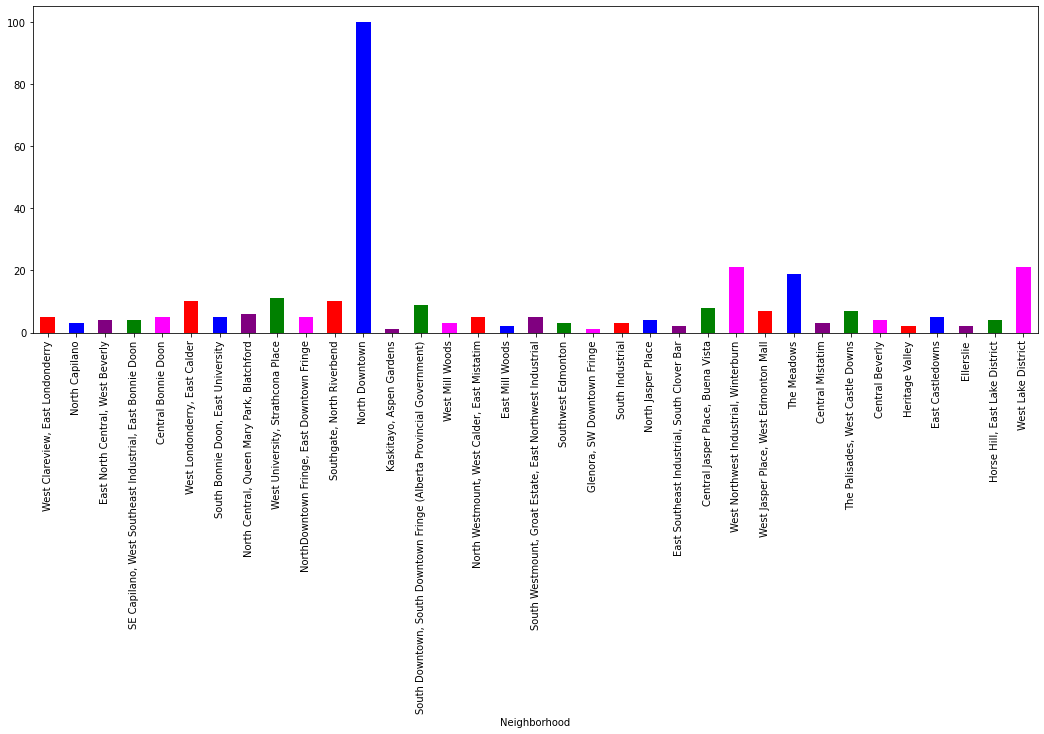

In [31]:
df = edmonton_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6), color=['red', 'blue', 'purple', 'green', 'fuchsia'])

As we can see from the above bar chart, there are many neighborhoods with less than 5 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods with more than 5 venues.

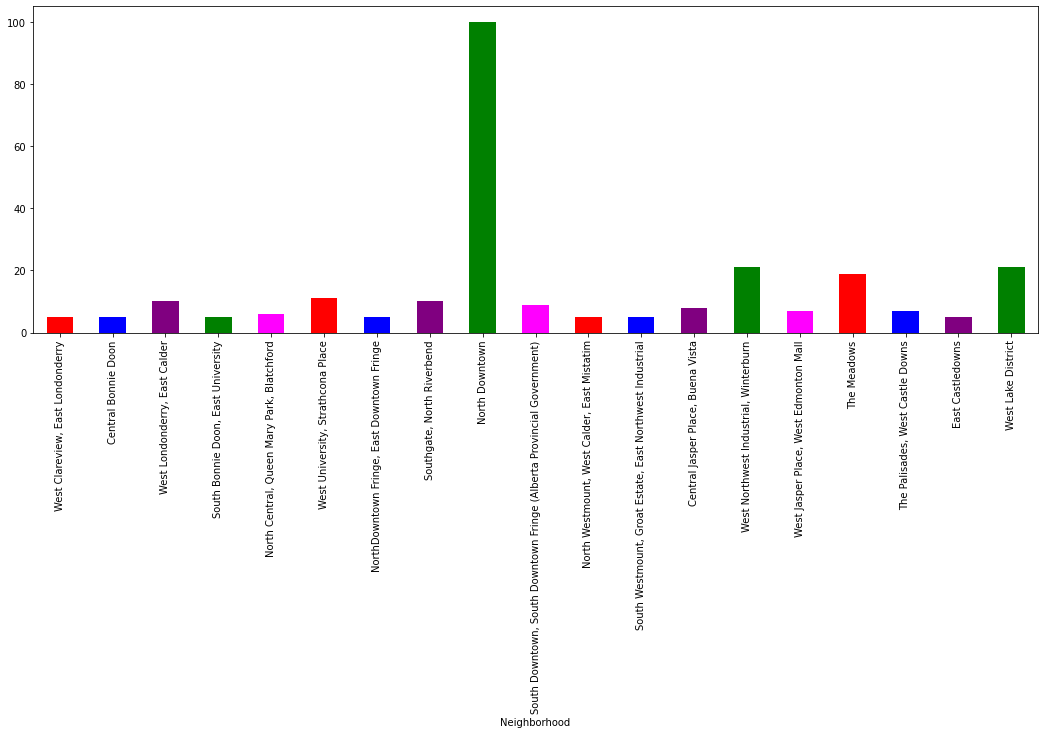

In [32]:
df = df[df >= 5]
df.plot.bar(figsize=(18,6), color=['red', 'blue', 'purple', 'green', 'fuchsia'])

#### Analyzing each neighborhood

In [33]:
edmonton_onehot = pd.get_dummies(edmonton_venues[['Venue Category']], prefix="", prefix_sep="")

edmonton_onehot['Neighborhood'] = edmonton_venues['Neighborhood'] 

fixed_columns = [edmonton_onehot.columns[-1]] + list(edmonton_onehot.columns[:-1])
edmonton_onehot = edmonton_onehot[fixed_columns]

edmonton_onehot.head()


,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Workshop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Business Service,Butcher,Café,Casino,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,College Gym,College Residence Hall,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Department Store,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Driving Range,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Health & Beauty Service,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Paintball Field,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Pub,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Skating Rink,Ski Trail,Smoke Shop,Soccer Field,Soccer Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Shop
0,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by neighborhood and by taking the mean of the frequency

In [34]:
edmonton_grouped = edmonton_onehot.groupby('Neighborhood').mean().reset_index()
edmonton_grouped.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Workshop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Business Service,Butcher,Café,Casino,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,College Gym,College Residence Hall,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Department Store,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Driving Range,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Health & Beauty Service,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Paintball Field,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Pub,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Skating Rink,Ski Trail,Smoke Shop,Soccer Field,Soccer Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Shop
0,Central Beverly,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Central Bonnie Doon,0.2,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.000000,0.2,0.0,0.0
2,"Central Jasper Place, Buena Vista",0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Central Mistatim,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0
4,East Castledowns,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [35]:
print (edmonton_venues['Venue Category'].value_counts())

Coffee Shop                      21
Sandwich Place                   15
Fast Food Restaurant             14
Pharmacy                         11
Pub                               9
Restaurant                        9
Hotel                             7
Furniture / Home Store            6
Café                              6
Grocery Store                     6
Bank                              6
Convenience Store                 5
Gym                               5
Pizza Place                       5
Liquor Store                      5
Bus Station                       5
Indian Restaurant                 4
Bakery                            4
Smoke Shop                        4
Asian Restaurant                  4
Mexican Restaurant                4
Gas Station                       3
American Restaurant               3
Breakfast Spot                    3
Park                              3
French Restaurant                 3
Vietnamese Restaurant             3
Italian Restaurant          

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating top 10 venues

In [38]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = edmonton_grouped['Neighborhood']

for ind in np.arange(edmonton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(edmonton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Beverly,Smoke Shop,Construction & Landscaping,Grocery Store,Fried Chicken Joint,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
1,Central Bonnie Doon,American Restaurant,Water Park,Trail,Liquor Store,Electronics Store,Falafel Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant
2,"Central Jasper Place, Buena Vista",Sandwich Place,Sushi Restaurant,Pizza Place,Convenience Store,Salad Place,Bakery,Café,Fast Food Restaurant,Flower Shop,Falafel Restaurant
3,Central Mistatim,Warehouse Store,Casino,Liquor Store,Wine Shop,Falafel Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Electronics Store
4,East Castledowns,Plaza,Recreation Center,Liquor Store,Skating Rink,Food Truck,Department Store,Diner,Discount Store,Distribution Center,Dog Run


#### Cluster Neighborhoods
Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette coefficient to obtain the best value for the number of clusters.

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [40]:
edmonton_grouped_clustering = edmonton_grouped.drop('Neighborhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(edmonton_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(edmonton_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.3720631959243243
For n_clusters=3, The Silhouette Coefficient is 0.37746557374507167
For n_clusters=4, The Silhouette Coefficient is 0.20421151393585438
For n_clusters=5, The Silhouette Coefficient is 0.21701449692631913
For n_clusters=6, The Silhouette Coefficient is 0.1518278010326688
For n_clusters=7, The Silhouette Coefficient is 0.1929511880723329
For n_clusters=8, The Silhouette Coefficient is 0.1808537468980641
For n_clusters=9, The Silhouette Coefficient is 0.1718769853636927


As we can see, n_clusters=3 has highest Silhouette Coefficient. This means that 3 should be the optimal number of clusters.

In [41]:
#Dividing venues in 3 clusters
kclusters = 3

edmonton_grouped_clustering = edmonton_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(edmonton_grouped_clustering)

kmeans.labels_[0:10] 


array([0, 0, 0, 0, 0, 0, 0, 0, 2, 1], dtype=int32)

In [42]:
#Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
neighborhoods_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

edmonton_merged = edmonton_data

edmonton_merged = edmonton_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

edmonton_merged.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413,0.0,Bus Station,Buffet,Mexican Restaurant,Record Shop,Toy / Game Store,Fast Food Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop
1,T6A,Edmonton,North Capilano,53.5483,-113.4080,0.0,Bus Station,Playground,Ski Trail,Department Store,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
2,T5B,Edmonton,"East North Central, West Beverly",53.5766,-113.4608,0.0,Smoke Shop,Construction & Landscaping,Grocery Store,Fried Chicken Joint,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
3,T6B,Edmonton,"SE Capilano, West Southeast Industrial, East B...",53.5322,-113.4404,0.0,Business Service,Home Service,Playground,Bar,Falafel Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant
4,T5C,Edmonton,Central Londonderry,53.6129,-113.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NaN values have to be dropped

In [44]:
edmonton_merged1=edmonton_merged.dropna()
edmonton_merged1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413,0.0,Bus Station,Buffet,Mexican Restaurant,Record Shop,Toy / Game Store,Fast Food Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop
1,T6A,Edmonton,North Capilano,53.5483,-113.4080,0.0,Bus Station,Playground,Ski Trail,Department Store,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
2,T5B,Edmonton,"East North Central, West Beverly",53.5766,-113.4608,0.0,Smoke Shop,Construction & Landscaping,Grocery Store,Fried Chicken Joint,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
3,T6B,Edmonton,"SE Capilano, West Southeast Industrial, East B...",53.5322,-113.4404,0.0,Business Service,Home Service,Playground,Bar,Falafel Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant
5,T6C,Edmonton,Central Bonnie Doon,53.5182,-113.4769,0.0,American Restaurant,Water Park,Trail,Liquor Store,Electronics Store,Falafel Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant


In [45]:
edmonton_merged1['Clusters'].astype(int)

0     0
1     0
2     0
3     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
28    0
29    0
30    0
31    0
32    0
33    2
34    0
35    2
36    0
37    0
Name: Clusters, dtype: int64

In [46]:
clusters =3
clust = edmonton_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(clust)

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Finally, let's visualize the resulting clusters

In [47]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(edmonton_merged1['Latitude'], edmonton_merged1['Longitude'], edmonton_merged1['Neighborhood'], edmonton_merged1['Clusters'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Results 
Let’s examine the clusters and find the discriminating venue categories that identify each cluster. For this purpose lets also print the ten most common venue category in each cluster.

In [48]:
#cluster 0
cluster_0 = edmonton_merged1.loc[edmonton_merged1['Clusters'] == 0, edmonton_merged1.columns[[2] + list(range(5, edmonton_merged1.shape[1]))]]
cluster_0

,Neighborhood,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"West Clareview, East Londonderry",0.0,Bus Station,Buffet,Mexican Restaurant,Record Shop,Toy / Game Store,Fast Food Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop
1,North Capilano,0.0,Bus Station,Playground,Ski Trail,Department Store,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
2,"East North Central, West Beverly",0.0,Smoke Shop,Construction & Landscaping,Grocery Store,Fried Chicken Joint,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
3,"SE Capilano, West Southeast Industrial, East B...",0.0,Business Service,Home Service,Playground,Bar,Falafel Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant
5,Central Bonnie Doon,0.0,American Restaurant,Water Park,Trail,Liquor Store,Electronics Store,Falafel Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Fast Food Restaurant
6,"West Londonderry, East Calder",0.0,Shopping Mall,Arts & Crafts Store,Hockey Arena,Butcher,Bakery,Dog Run,Baseball Field,Comic Shop,Grocery Store,Recreation Center
7,"South Bonnie Doon, East University",0.0,American Restaurant,Pharmacy,Coffee Shop,Mediterranean Restaurant,Flower Shop,Fried Chicken Joint,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant
8,"North Central, Queen Mary Park, Blatchford",0.0,Pharmacy,Café,Bakery,Bank,Music Venue,Theater,Fast Food Restaurant,Food Truck,Food & Drink Shop,Flower Shop
9,"West University, Strathcona Place",0.0,College Gym,Theater,Diner,College Residence Hall,Fast Food Restaurant,Coffee Shop,Pub,Bank,Sandwich Place,Eastern European Restaurant
10,"NorthDowntown Fringe, East Downtown Fringe",0.0,Grocery Store,Café,Soccer Stadium,Gift Shop,Gym,Falafel Restaurant,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Wine Shop


In [49]:
cluster_0 = edmonton_merged1.loc[edmonton_merged1['Clusters'] == 0, edmonton_merged1.columns[[0] + 
                                                                                    list(range(5, edmonton_merged1.shape[1]))]]
venues0 = (cluster_0['1st Most Common Venue'].append(
    cluster_0['2nd Most Common Venue']).append(
    cluster_0['3rd Most Common Venue']).append(
    cluster_0['4th Most Common Venue']).append(
    cluster_0['5th Most Common Venue']).append(
    cluster_0['6th Most Common Venue']).append(
    cluster_0['7th Most Common Venue']).append(
    cluster_0['8th Most Common Venue']).append(
    cluster_0['9th Most Common Venue']).append(
    cluster_0['10th Most Common Venue']))

print(venues0.value_counts().head(10))

Fast Food Restaurant           17
Discount Store                 16
Eastern European Restaurant    15
Distribution Center            14
Dog Run                        14
Flower Shop                    13
Diner                          13
Electronics Store              12
Food & Drink Shop              11
Falafel Restaurant             11
dtype: int64


In [50]:
#cluster 1
cluster_1 = edmonton_merged1.loc[edmonton_merged1['Clusters'] == 1, edmonton_merged1.columns[[2] + list(range(5, edmonton_merged1.shape[1]))]]
cluster_1

,Neighborhood,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Glenora, SW Downtown Fringe",1.0,Portuguese Restaurant,Wine Shop,Fried Chicken Joint,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store,Falafel Restaurant


In [51]:
cluster_1 = edmonton_merged1.loc[edmonton_merged1['Clusters'] == 1, edmonton_merged1.columns[[0] + 
                                                                                    list(range(5, edmonton_merged1.shape[1]))]]
venues1 = (cluster_1['1st Most Common Venue'].append(
    cluster_1['2nd Most Common Venue']).append(
    cluster_1['3rd Most Common Venue']).append(
    cluster_1['4th Most Common Venue']).append(
    cluster_1['5th Most Common Venue']).append(
    cluster_1['6th Most Common Venue']).append(
    cluster_1['7th Most Common Venue']).append(
    cluster_1['8th Most Common Venue']).append(
    cluster_1['9th Most Common Venue']).append(
    cluster_1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Dog Run                        1
Diner                          1
Fried Chicken Joint            1
Electronics Store              1
Portuguese Restaurant          1
Distribution Center            1
Discount Store                 1
Wine Shop                      1
Eastern European Restaurant    1
Falafel Restaurant             1
dtype: int64


In [52]:
#cluster 2
cluster_2 = edmonton_merged1.loc[edmonton_merged1['Clusters'] == 2, edmonton_merged1.columns[[2] + list(range(5, edmonton_merged1.shape[1]))]]
cluster_2

,Neighborhood,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Heritage Valley,2.0,Gymnastics Gym,Rest Area,Wine Shop,Fried Chicken Joint,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store
35,Ellerslie,2.0,Motorcycle Shop,Gymnastics Gym,Furniture / Home Store,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store,Falafel Restaurant


In [53]:
cluster_2 = edmonton_merged1.loc[edmonton_merged1['Clusters'] == 2, edmonton_merged1.columns[[0] + 
                                                                                    list(range(5, edmonton_merged1.shape[1]))]]
venues2 = (cluster_2['1st Most Common Venue'].append(
    cluster_2['2nd Most Common Venue']).append(
    cluster_2['3rd Most Common Venue']).append(
    cluster_2['4th Most Common Venue']).append(
    cluster_2['5th Most Common Venue']).append(
    cluster_2['6th Most Common Venue']).append(
    cluster_2['7th Most Common Venue']).append(
    cluster_2['8th Most Common Venue']).append(
    cluster_2['9th Most Common Venue']).append(
    cluster_2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Electronics Store              2
Distribution Center            2
Dog Run                        2
Diner                          2
Discount Store                 2
Gymnastics Gym                 2
Eastern European Restaurant    2
Fried Chicken Joint            1
Rest Area                      1
Motorcycle Shop                1
dtype: int64


### 6. Discussion 
Lets visulaize the top 10 most common venue categories in each of the cluster.

IndexError: list index out of range

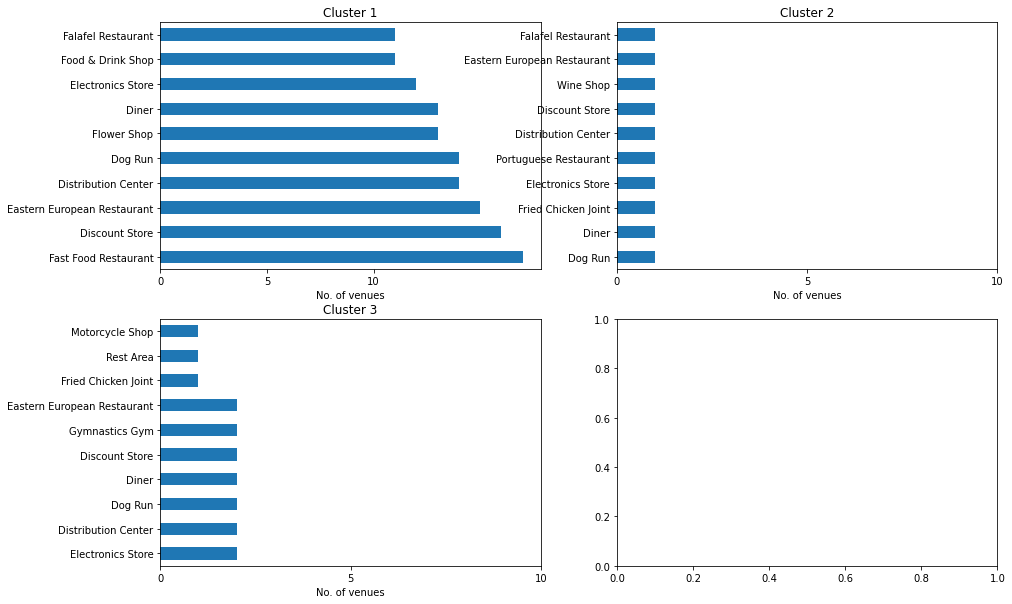

In [54]:
df_list = [venues0 ,venues1, venues2]
fig, axes = plt.subplots(2, 2)

count = 0
for r in range(2):
    for c in range(2):
        df_list[count].value_counts().head(10).plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business:

The cluster 1 is situated within the central part of the city, and is saturated with fast food restaurants and some other type restaurants, hence opening one here is not the best choice. I could suggest that this cluster don't need more restaurants, but hotel/hostel, health & beauty shop, or bakery could be a good idea for business. 

On the cotrary, cluster 3 is situated outside the central part of the city, and has one fast food restaurant. Suggestion could be a coffee shop or another fast food restaurant. If a deeper analysis could be done, due to location a major project could be suggested, as large shopping mall, indoor climbing park or amusement park for children.

Cluster 2 is the smallest one and is located in central part of the city. The most popular venue there are food and wine, so may be cluster 2 is a good place for a bar, pub or disco.

I came with several suggestions, but deeper research needs to be done for best result.

### 7. Conclusion

This section concludes the predictive analysis for finding suitable location to open a new business in Edmonton. I have used different python packages to extract, scrap the necessary data from Wikipedia and to visualise data, also Foursquare API was used to explore the venues in neighborhoods. Final section of the project was to group venues in clusters and define the characteristics for that particular cluster.

I have found three clusters, to of which are situated in the central part of the Edmonton, however the third cluster is located outside. A few examples for the applications that the clusters can be used for have also been discussed. This analysis is rather comprehensive and visual, namely a map showing the clusters have been provided. So this information can be used by stakeholders to decide the location for the particular type of business. 

As a futher work could be in-deapth analysis including population in each neighborhood and income rate. Some more data sources can be used to obtain more venues in each neighborhood. Another clustering analysis could be done to create a better decision model.

## Thank you!